# Analysis
* This notebook cleans code for analyzing 'parsed1.csv'
* Contains some preliminary analysis.

In [95]:
import ast
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import regex as re
import seaborn as sns

from scipy.stats import chi2_contingency

In [2]:
df = pd.read_csv("parsed1.csv", index_col = 0)
df.drop(columns = ['docket_no'], inplace = True)

In [3]:
df.head()

,offenses,offense_date,arrest_dt,case_status,arresting_officer,attorney,dob,zip,bail_set_by,bail_amount,bail_paid,bail_date,bail_type,prelim_hearing_dt,prelim_hearing_time,parsed_offenses
0,"['Rape Forcible Compulsion', 'Rape Forcible Co...",5/28/20,7/27/20,Active,"Bengochea, William",Defender Association of Philadelphia,5/19/93,19123,"Bernard, Francis X.",300000,0,7/28/20,Monetary,7/28/20,4:49 AM,"['False Imprisonment', 'Indec Asslt-W/O Cons O..."
1,['Aggravated Assault - Attempts to cause SBI o...,5/4/20,5/4/20,Active,"Soares, Baldomiro J. Jr.",Defender Association of Philadelphia,5/5/97,19121,E-Filing Judge,50000,5000,5/5/20,Monetary,5/4/20,5:33 PM,['Aggravated Assault - Attempts to cause SBI o...
2,"['Simple Assault', 'Simple Assault', 'Reckless...",2/2/20,2/12/20,Active,"Jones, James",Defender Association of Philadelphia,11/15/86,19124,"Stack, Patrick",7500,750,2/13/20,Monetary,2/13/20,8:22 AM,"['Recklessly Endangering Another Person', 'Sim..."
3,"['Contraband/Controlled Substance', 'Contraban...",2/10/20,2/21/20,Active,"Balmer, James M.",Defender Association of Philadelphia,12/13/80,19135,"Bernard, Francis X.",5000,0,2/21/20,Unsecured,2/21/20,8:34 PM,"['Contraband/Controlled Substance', 'Int Poss ..."
4,"['Manufacture, Delivery, or Possession With In...",3/13/20,3/14/20,Active,"Sima, Raymond",Richard T. Brown Jr.,11/5/97,19144,"Stack, Patrick",0,0,3/14/20,ROR,3/14/20,8:40 AM,"['Conspiracy', 'Int Poss Contr Subst By Per No..."


In [4]:
# convert string to datetime
#df["offense_date"] = pd.to_datetime(df["offense_date"])
df["arrest_dt"] = pd.to_datetime(df["arrest_dt"])
df["dob"] = pd.to_datetime(df["dob"])
df["bail_date"] = pd.to_datetime(df["bail_date"])
df["prelim_hearing_dt"] = pd.to_datetime(df["prelim_hearing_dt"])

# age column
df['age'] = df['dob'].apply(lambda x: 2020-x.year)

# public defender column: 1 if public defender, 0 if private defender
df["public_defender"] = df["attorney"].apply(lambda x: 1 if x =='Defender Association of  Philadelphia' else 0)

# convert type of "offenses" and "parsed_offenses" from string representation of list to list
df["offenses"] = df["offenses"].apply(lambda x: ast.literal_eval(x))
df["parsed_offenses"] = df["parsed_offenses"].apply(lambda x: ast.literal_eval(x))

# zipcode: remove everything after hyphen
df["zipcode_clean"] = df["zip"].apply(lambda x: re.sub('-.*$','',x) if type(x) == str else x)

# Create column indicating whether zipcode is in philadelphia or not
philly_zipcode = list(range(19102, 19155))
philly_zipcode = [str(item) for item in philly_zipcode]
df['philly_zipcode'] = df['zipcode_clean'].apply(lambda x: 1 if x in philly_zipcode else 0)

Note:
* For some reason, 'offense date' has multiple formats, so I couldn't easily convert to datetime format. Hopefully, the newly parsed dockets will all have uniform date format.

In [13]:
# save
# df.to_csv("../Data/parsed1_cleaned.csv")

## Preliminary analysis

In [5]:
df["public_defender"].value_counts()

1    9148
0    4290
Name: public_defender, dtype: int64

In [6]:
df["bail_type"].value_counts()

Monetary       5534
ROR            3920
Unsecured      3622
Nonmonetary     156
Nominal           1
Name: bail_type, dtype: int64

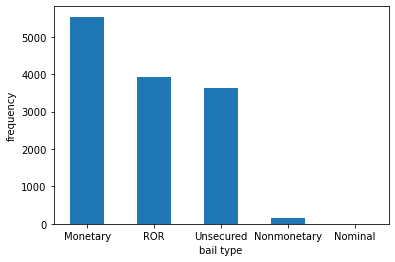

In [9]:
# types of bail
fig, ax = plt.subplots()
ax = df['bail_type'].value_counts().plot(kind = 'bar')
ax.set_xlabel('bail type')
ax.set_ylabel('frequency')
ax.xaxis.set_tick_params(rotation=0)
plt.show()

<b> Bail amount for monetary bail </b>

In [10]:
df[df["bail_type"] == "Monetary"].bail_amount.describe()

count    5.534000e+03
mean     9.940039e+04
std      2.404077e+05
min      0.000000e+00
25%      1.000000e+04
50%      2.500000e+04
75%      1.000000e+05
max      5.000000e+06
Name: bail_amount, dtype: float64

In [11]:
# median bail amount
print('median bail amount: ', df[df["bail_type"] == "Monetary"].bail_amount.median())

median bail amount:  25000.0


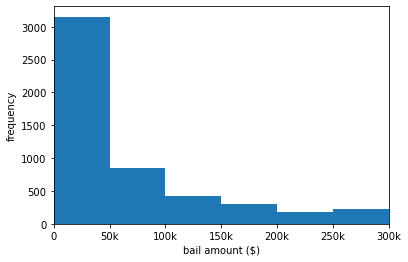

In [12]:
# distribution of bail amount for monetary bail
fig, ax = plt.subplots()
ax = df[df["bail_type"] == "Monetary"].bail_amount.plot.hist(bins = 100)
ax.set_xlim((0,300000))
ax.set_xlabel('bail amount ($)')
ax.set_ylabel('frequency')
plt.xticks(range(0, 350000, 50000), ['0','50k', '100k', '150k', '200k', '250k', '300k'])
plt.show()

In [ ]:
# median bail amount over time 

<b> Quesiton:</b> When a bail is paid, is it always 10% of the bail amount? Yes

In [13]:
# when a bail is paid, it's always 10% of the bail amount
(df[df["bail_paid"] > 0].bail_amount * 0.1 == df[df["bail_paid"] > 0].bail_paid).value_counts()

True    3005
dtype: int64

<b> Number of cases over time </b>

In [23]:
day_count = df['arrest_dt'].value_counts()
day_count.keys().max()

Timestamp('2020-07-29 00:00:00')

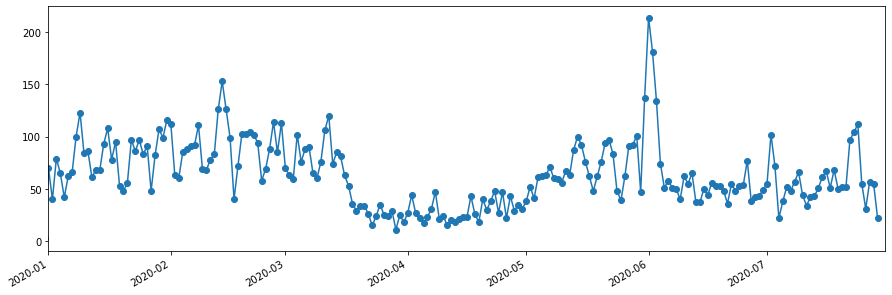

In [26]:
plt.figure(figsize = (15,5))
plt.scatter(day_count.index, day_count.values)
day_count.plot()
plt.xlim('2020-01-01','2020-07-31')
plt.show()

In [ ]:
# maybe we should exclude those arrested from 05-31 to 06-03

## Q1.1

## Q1.2 

## Q1.3 What neighborhoods are highly impacted by bail?

The following visualizations shows that monetary bail largely impacts those who live in areas with severe poverty. 
* Left: Number of monetary bail cases by zip code. 
    * (We can regenerate the image for entire year of 2020 once we have the data) 
* Right: From US Census Bureau ASC 5-year estimate from 2018. 
    * data and link to table stored at 'data/poverty'.
    * Maybe we can grab 2020 data

data          |  visualization
:-------------------------:|:-------------------------:
Case count of monetary bail by zip code | <img src="visualizations/monetary_bail_case_count.png" alt="drawing" width="800"/>  |
Percentage of population living under poverty by zip code | <img src="visualizations/percent_below_poverty.png" alt="drawing" width="800"/> | 

The following visualizations show that the median household income is higher than median bail amount (\$25K) in many zip codes. 
* Left: median monetary bail amount by zip code.
    * Median computed only for zipcodes that had 6 or more cases.  
    * Median bail amount is usually \$25K
    * We can regenerate the image once we have 2020 data available. 
* Right: median household income by zipcode
    * From US Cenus Bureau 2018 ASC 5-year estimate from 2018. 
    * data and link to table stored at 'data/income' 
    * Maybe we can grab 2020 data


data          |  visualization
:-------------------------:|:-------------------------:
Median monetary bail amount by zip code            | <img src="visualizations/bail_amount.png" alt="drawing" width="800"/> |  
Median household income by zip code | <img src="visualizations/income.png" alt="drawing" width="800"/>


## Q2.1 Relationship between bail type / amount and various factors

### Q: Are bail type and attorney type related?

In [235]:
df_bail_attorney = pd.crosstab(index = df['public_defender'], columns =df['bail_type'])
df_bail_attorney

bail_type,Monetary,Nominal,Nonmonetary,ROR,Unsecured
public_defender,,,,,
0,2346,1,16,771,974
1,3188,0,140,3149,2648


In [236]:
# since there are only a few nominal and non-monetary, combine them into 'other'
df_bail_attorney['Other'] = df_bail_attorney['Nominal'] + df_bail_attorney['Nonmonetary']

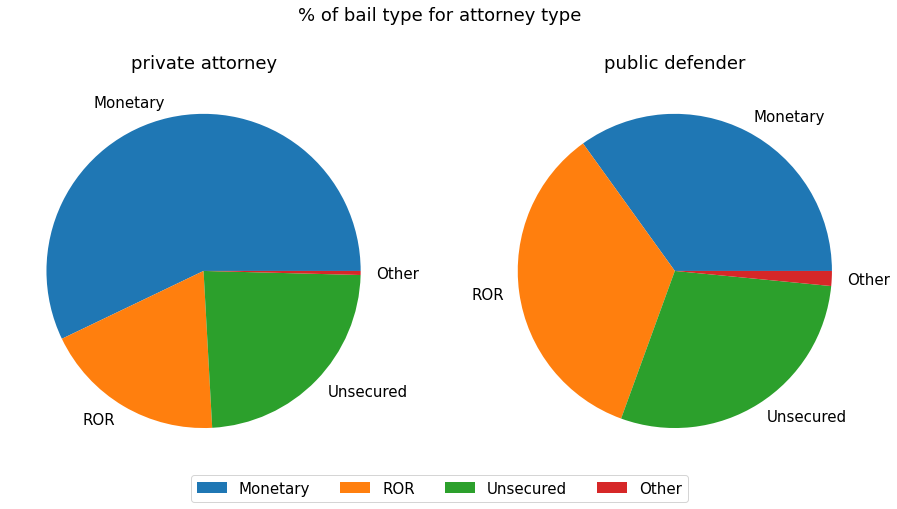

In [237]:
bail_types = ['Monetary','ROR', 'Unsecured', 'Other']
fig, ax = plt.subplots(ncols = 2, figsize = (15, 15))
plt.rcParams['font.size'] = 15
fig.suptitle('% of bail type for attorney type')
ax[0].pie(df_bail_attorney.loc[0,bail_types], labels = bail_types)
ax[0].set_title('private attorney')
ax[1].pie(df_bail_attorney.loc[1,bail_types], labels = bail_types)
ax[1].set_title('public defender')
# common legend
fig.subplots_adjust(top=1.35, left=0.1, right=0.9, bottom=0.12)  # create some space below the plots by increasing the bottom-value
ax.flatten()[-2].legend(loc='upper center', bbox_to_anchor=(1.1, 0), ncol=4)

plt.show()

In [238]:
# remove 'nominal' since we don't have enough cases 
df_bail_attorney.drop(columns = ['Nominal', 'Nonmonetary', 'Other'], inplace = True)

# chi-squared test
chi2, p, dof, ex = chi2_contingency(df_bail_attorney)
print('p-value of chi-square test: ', p)

p-value of chi-square test:  3.468844034416293e-130


* chi-square test tells us that **bail type and attorney type are related.**  
* Looking at the pie chart for cases with public defenders, around 1/3 of cases end up with monetary, ROR, or unsecured bail. In contrast, cases with private attorney representation ends up with higher proportion of monetary bail cases. 
* This might be because defendants with serious offenses (and therefore more likely to end up with monetary bail) may be more likely to seek representation by private attornies.

## Q2.2

## Q2.3 What are the strongest factors determining bail type / bail amount?

* See Q2.1 for starters

### Prepare features

In [19]:
df.drop(columns = ['dob', 'arresting_officer', 'attorney', 'zip'], inplace = True)

## Q2.4